In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product k.csv', parse_dates=['Month-Year'])


In [3]:
sales_k= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_k = sales_k.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_k.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,505010,797644,8355561
1,2019-02-01,521132,823109,8622305
2,2019-03-01,580897,917505,9611137
3,2019-04-01,612559,967514,10134996
4,2019-05-01,550697,869805,9111468


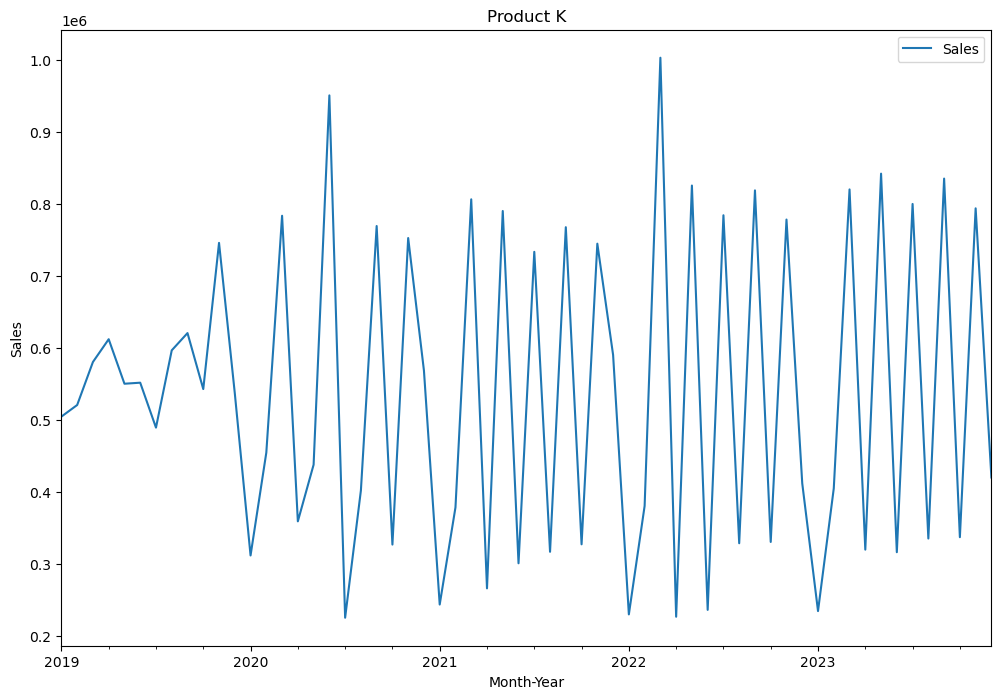

In [5]:
ax = sales_k.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product K')
plt.legend(['Sales'])
plt.show()


In [6]:
train= sales_k[:57]
test=sales_k[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

13:29:24 - cmdstanpy - INFO - Chain [1] start processing
13:29:24 - cmdstanpy - INFO - Chain [1] done processing
13:29:46 - cmdstanpy - INFO - Chain [1] start processing
13:29:47 - cmdstanpy - INFO - Chain [1] done processing
13:29:51 - cmdstanpy - INFO - Chain [1] start processing
13:29:51 - cmdstanpy - INFO - Chain [1] done processing
13:29:55 - cmdstanpy - INFO - Chain [1] start processing
13:29:56 - cmdstanpy - INFO - Chain [1] done processing
13:30:05 - cmdstanpy - INFO - Chain [1] start processing
13:30:05 - cmdstanpy - INFO - Chain [1] done processing
13:30:11 - cmdstanpy - INFO - Chain [1] start processing
13:30:13 - cmdstanpy - INFO - Chain [1] done processing
13:30:17 - cmdstanpy - INFO - Chain [1] start processing
13:30:18 - cmdstanpy - INFO - Chain [1] done processing
13:30:21 - cmdstanpy - INFO - Chain [1] start processing
13:30:22 - cmdstanpy - INFO - Chain [1] done processing
13:30:26 - cmdstanpy - INFO - Chain [1] start processing
13:30:27 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   123473.610125  
1   138871.621058  
2    68602.340894  
3    71302.149035  
4    71968.623553  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
65,0.500,1.00,multiplicative,65339.929528
38,0.200,0.10,additive,66714.822514
50,0.300,0.10,additive,67445.330891
26,0.100,0.10,additive,68140.158660
63,0.500,0.10,multiplicative,68390.621720
...,...,...,...,...
25,0.100,0.01,multiplicative,137818.468329
37,0.200,0.01,multiplicative,137830.795411
49,0.300,0.01,multiplicative,138452.346742
1,0.001,0.01,multiplicative,138871.621058


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale= 1.0, seasonality_mode= 'multiplicative', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

13:54:13 - cmdstanpy - INFO - Chain [1] start processing
13:54:14 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_k['Market Size']
future_dates['Marketing Expense'] = sales_k['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,797644,8355561
1,2019-02-01,823109,8622305
2,2019-03-01,917505,9611137
3,2019-04-01,967514,10134996
4,2019-05-01,869805,9111468
5,2019-06-01,872080,9135293
6,2019-07-01,773482,8102450
7,2019-08-01,943094,9879188
8,2019-09-01,980970,10275945
9,2019-10-01,1178924,12349572


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,533162.771082,463195.364303,600254.081133
58,2023-11-01,672704.173911,607356.606320,742140.634579
59,2023-12-01,372244.870729,300991.553364,439669.357745


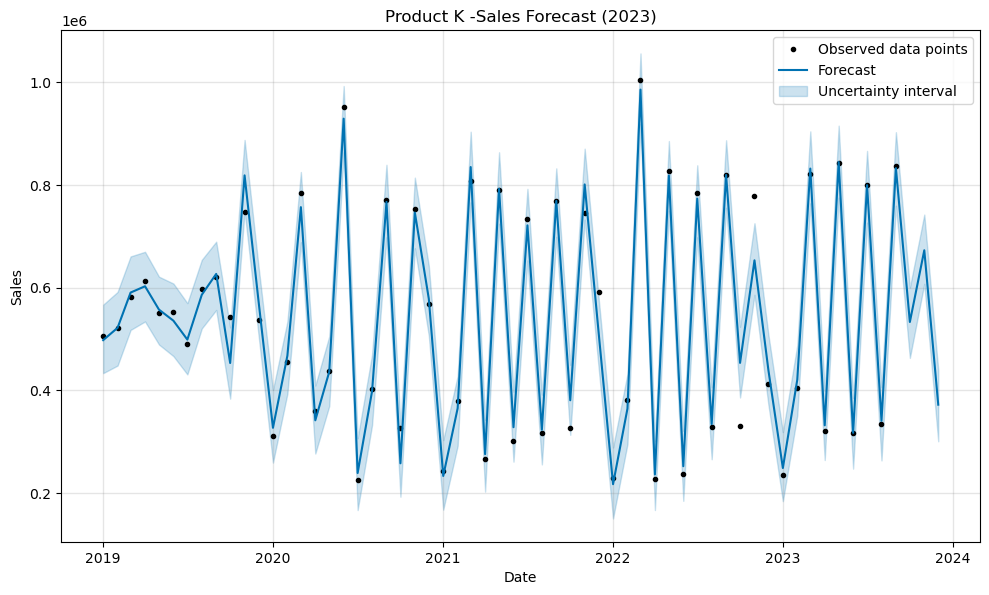

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product K -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

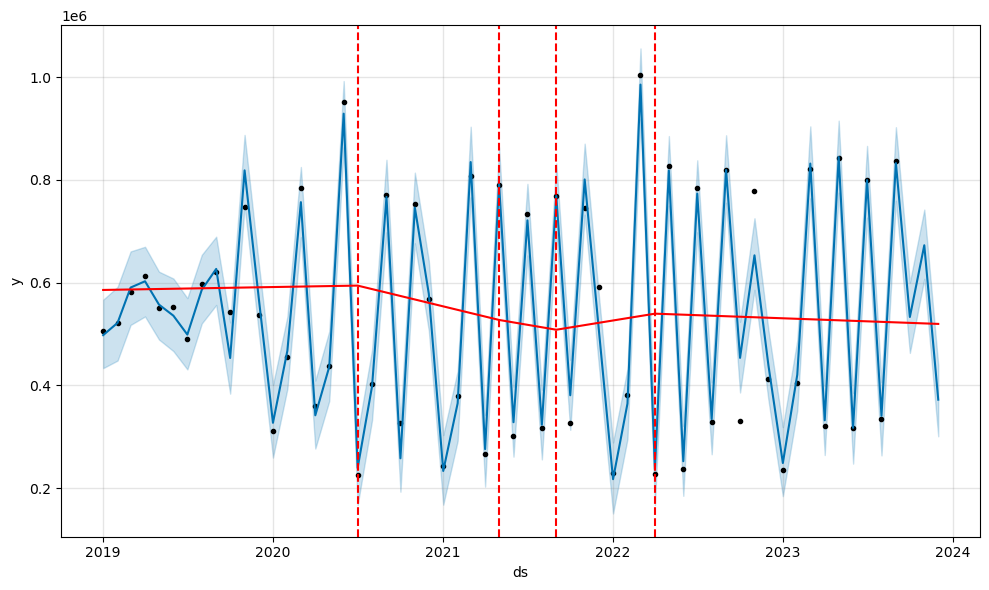

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

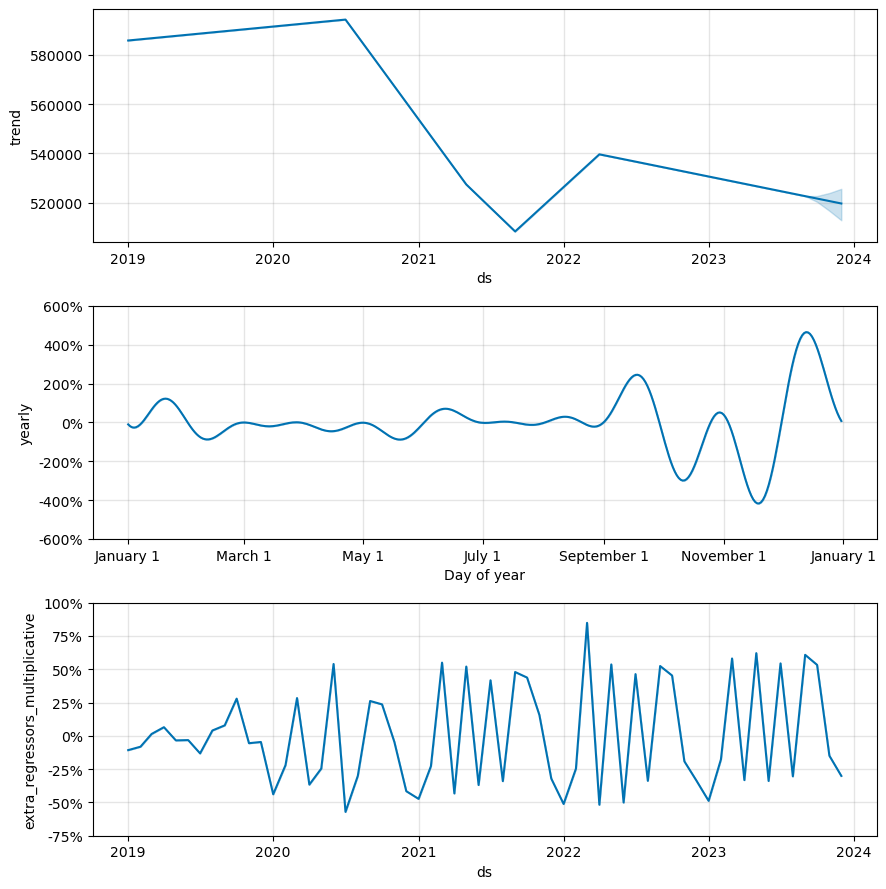

In [21]:
fig2 = model.plot_components(forecast)

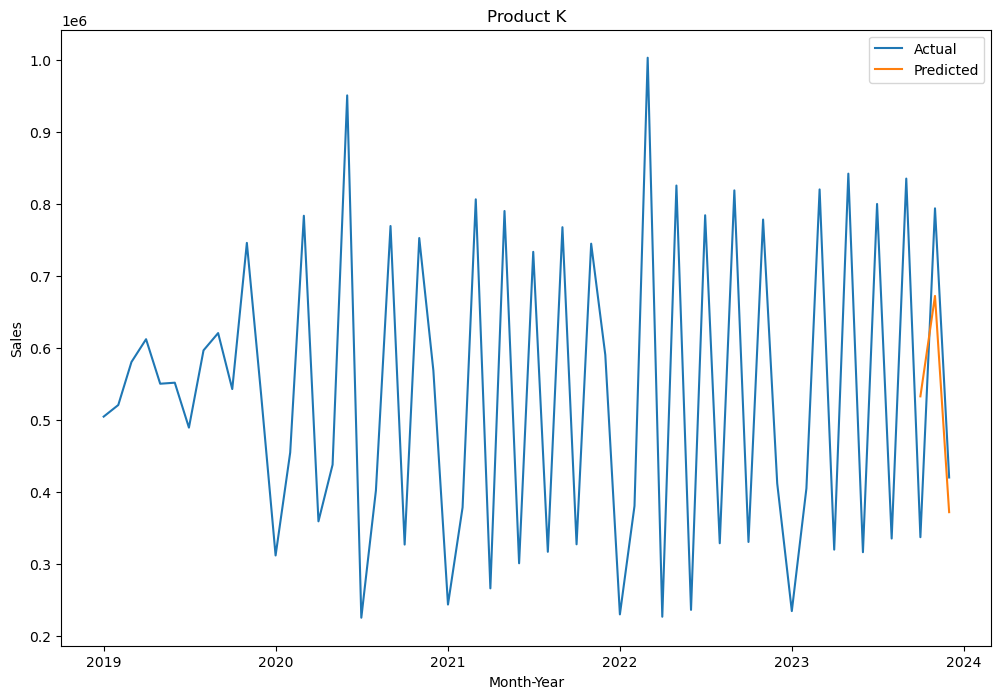

In [22]:
# Reset index of sales_b DataFrame
sales_k_reset_index = sales_k.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_k_reset_index['ds'], sales_k_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product K')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 121860.242
MAPE - FB PROPHET: 0.283
MSE - FB PROPHET: 18477380257.277
RMSE - FB PROPHET: 135931.528


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,4.226108e+09,65008.522588,38523.335439,0.117049,0.005327,0.100246,0.666667
1,22 days,4.415300e+09,66447.720087,48794.097888,0.163872,0.077088,0.146987,0.666667
2,23 days,5.358377e+08,23148.168173,21994.194597,0.062981,0.070851,0.062620,1.000000
3,25 days,1.070185e+10,103449.750760,74844.801223,0.215098,0.070851,0.177731,0.666667
4,27 days,1.128783e+10,106244.182288,82003.427160,0.270086,0.223413,0.225036,0.666667
5,28 days,1.042579e+09,32288.992920,25836.099042,0.096208,0.056526,0.088220,1.000000
6,47 days,1.912138e+09,43728.001612,35546.011404,0.076703,0.056526,0.073868,0.666667
7,49 days,1.704936e+09,41290.873383,33886.660201,0.061891,0.081456,0.061605,0.666667
8,51 days,1.889681e+09,43470.457221,39751.737408,0.069975,0.081456,0.069498,0.666667
9,52 days,6.039598e+08,24575.593471,23970.804543,0.049709,0.032936,0.048009,1.000000


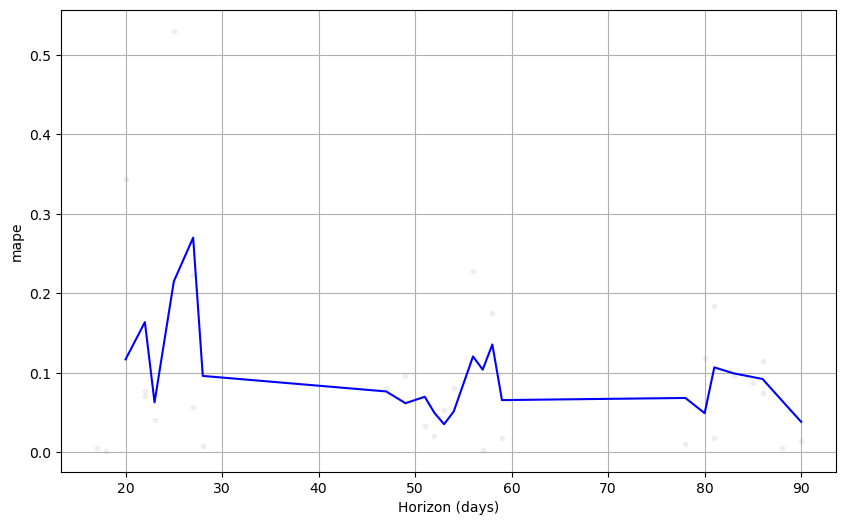

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

57    337462
58    794412
59    420417
Name: y, dtype: int64

In [30]:
pred

57    533162.771082
58    672704.173911
59    372244.870729
Name: yhat, dtype: float64